**Marius Orehovschi & Caleb Chong**

Fall 2019

CS497: Advanced Perception

Project 2: Speech Recognition

**Train CNN and LSTM on raw sound files**

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import librosa
import IPython.display as ipd
from scipy.io import wavfile 

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install librosa

In [0]:
'''
Simple convolutional neural network that can distinguish among 30 words in 1-second recordings sampled at 8000kHz
Inspired by Aravind Pai's speech tutorial 
https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/
'''
class SpeechConv(tf.keras.Model):
    def __init__(self, n_classes):
        super(SpeechConv, self).__init__()
        self.conv1d1 = tf.keras.layers.Conv1D(filters=8, kernel_size=13, strides=1, padding='valid', 
                                              activation=tf.nn.relu)
        self.maxpool1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=3)
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        
        self.conv1d2 = tf.keras.layers.Conv1D(filters=16, kernel_size=11, strides=1, padding='valid', 
                                              activation=tf.nn.relu)
        self.maxpool2 = tf.keras.layers.MaxPool1D(pool_size=3, strides=3)
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        
        self.conv1d3 = tf.keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding='valid', 
                                              activation=tf.nn.relu)
        self.maxpool3 = tf.keras.layers.MaxPool1D(pool_size=3, strides=3)
        self.dropout3 = tf.keras.layers.Dropout(0.3)
        
        self.conv1d4 = tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='valid', 
                                              activation=tf.nn.relu)
        self.maxpool4 = tf.keras.layers.MaxPool1D(pool_size=3, strides=3)
        self.dropout4 = tf.keras.layers.Dropout(0.3)
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dropout5 = tf.keras.layers.Dropout(0.3)
        
        self.dense2 = tf.keras.layers.Dense(128, activation=tf.nn.softmax)
        self.dropout6 = tf.keras.layers.Dropout(0.3)
        
        self.dense3 = tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
    
    def call(self, inputs):
        x = self.conv1d1(inputs)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv1d2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.conv1d3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = self.conv1d4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)
        
        x = self.flatten(x)
        
        x = self.dense1(x)
        x = self.dropout5(x)
        
        x = self.dense2(x)
        x = self.dropout6(x)
        
        return self.dense3(x)
    
    def build_graph(self, input_shape): 
        input_shape_nobatch = input_shape[1:]
        self.build(input_shape)
        inputs = tf.keras.Input(shape=input_shape_nobatch)
        
        if not hasattr(self, 'call'):
            raise AttributeError("User should define 'call' method in sub-class model!")
        
        _ = self.call(inputs)
    

In [5]:
# load the Tensorflow speech recognition data
data_path = 'drive/My Drive/Speech/tf_speech'

x_val = np.load(data_path + '/x_val.npy')
y_val = np.load(data_path + '/y_val.npy')
print('Validation shapes:', x_val.shape, y_val.shape)

x_test = np.load(data_path + '/x_test.npy')
y_test = np.load(data_path + '/y_test.npy')
print('Test shapes:', x_test.shape, y_test.shape)

x_train = np.load(data_path + '/x_train.npy')
y_train = np.load(data_path + '/y_train.npy')
print('Train shapes:', x_train.shape, y_train.shape)

labels = np.load(data_path + '/labels.npy')
print('Labels shape:', labels.shape)

Validation shapes: (1000, 8000) (1000,)
Test shapes: (7000, 8000) (7000,)
Train shapes: (56721, 8000) (56721,)
Labels shape: (30,)


In [6]:
# add singleton dimensions to features
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
print('New validation shape', x_val.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print('New test shape', x_test.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print('New train shape', x_train.shape)

New validation shape (1000, 8000, 1)
New test shape (7000, 8000, 1)
New train shape (56721, 8000, 1)


In [0]:
speech_conv = SpeechConv(30)
speech_conv.build_graph(x_train.shape)
speech_conv.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "speech_conv_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 884, 16)           0         
______________________________________

In [0]:
# train convolutional network on raw soundfiles
speech_conv = SpeechConv(len(labels))
speech_conv.build_graph(x_train.shape)
speech_conv.compile(optimizer='adam', metrics=['accuracy'], loss=['categorical_crossentropy'])

init_time = time.time()
history=speech_conv.fit(x_train, y_train ,epochs=100, batch_size=128, validation_data=(x_val,y_val))
total_training_time = time.time()-init_time
print('Total training time (100 epochs):', total_training_time)

Train on 56721 samples, validate on 1000 samples
Epoch 1/100
56721/56721 [==============================] - 10s 173us/sample - loss: 3.3542 - accuracy: 0.0501 - val_loss: 3.2886 - val_accuracy: 0.0770
Epoch 2/100
56721/56721 [==============================] - 9s 152us/sample - loss: 3.2765 - accuracy: 0.0594 - val_loss: 3.2404 - val_accuracy: 0.0750
Epoch 3/100
56721/56721 [==============================] - 9s 153us/sample - loss: 3.2432 - accuracy: 0.0629 - val_loss: 3.2051 - val_accuracy: 0.0830
Epoch 4/100
56721/56721 [==============================] - 9s 151us/sample - loss: 3.2285 - accuracy: 0.0646 - val_loss: 3.1745 - val_accuracy: 0.0930
Epoch 5/100
56721/56721 [==============================] - 9s 154us/sample - loss: 3.2112 - accuracy: 0.0659 - val_loss: 3.1518 - val_accuracy: 0.0810
Epoch 6/100
56721/56721 [==============================] - 9s 151us/sample - loss: 3.2055 - accuracy: 0.0673 - val_loss: 3.1445 - val_accuracy: 0.0730
Epoch 7/100
56721/56721 [===================

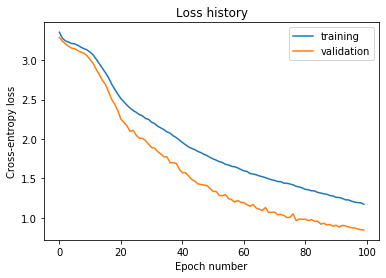

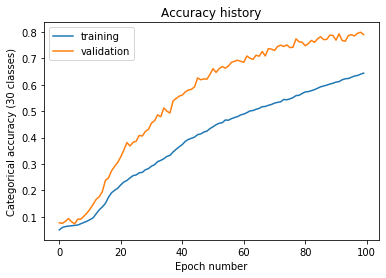

In [0]:
# plot loss history
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss history')
plt.xlabel('Epoch number')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# plot loss history
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy history')
plt.xlabel('Epoch number')
plt.ylabel('Categorical accuracy (30 classes)')
plt.legend()
plt.show()

In [0]:
# from the previous plots, it looks like the loss and accuracy don't fully plateau; train some more
init_time = time.time()
history=speech_conv.fit(x_train, y_train ,epochs=50, batch_size=128, validation_data=(x_val,y_val))
total_training_time = time.time()-init_time
print(f'Second round training time (50 epochs): {total_training_time}')

Train on 56721 samples, validate on 1000 samples
Epoch 1/50
56721/56721 [==============================] - 9s 154us/sample - loss: 1.1700 - accuracy: 0.6454 - val_loss: 0.8680 - val_accuracy: 0.7810
Epoch 2/50
56721/56721 [==============================] - 9s 153us/sample - loss: 1.1533 - accuracy: 0.6503 - val_loss: 0.8227 - val_accuracy: 0.7950
Epoch 3/50
56721/56721 [==============================] - 9s 153us/sample - loss: 1.1458 - accuracy: 0.6520 - val_loss: 0.8516 - val_accuracy: 0.7830
Epoch 4/50
56721/56721 [==============================] - 9s 153us/sample - loss: 1.1482 - accuracy: 0.6534 - val_loss: 0.7905 - val_accuracy: 0.8020
Epoch 5/50
56721/56721 [==============================] - 9s 151us/sample - loss: 1.1202 - accuracy: 0.6616 - val_loss: 0.8378 - val_accuracy: 0.7830
Epoch 6/50
56721/56721 [==============================] - 9s 154us/sample - loss: 1.1255 - accuracy: 0.6594 - val_loss: 0.8015 - val_accuracy: 0.8080
Epoch 7/50
56721/56721 [===========================

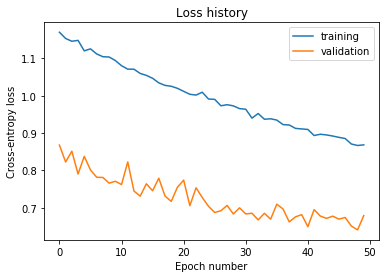

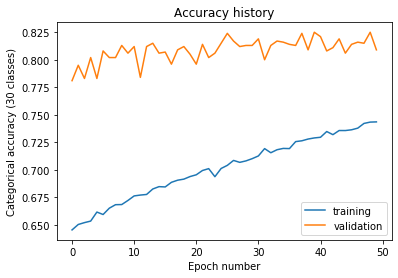

In [0]:
# plot loss history
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss history')
plt.xlabel('Epoch number')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# plot loss history
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy history')
plt.xlabel('Epoch number')
plt.ylabel('Categorical accuracy (30 classes)')
plt.legend()
plt.show()

In [0]:
# valuate model on test set
speech_conv.evaluate(x_test, y_test)

7000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6482985427720206, 0.81885713]

In [0]:
# test model with own recordings

In [0]:
!pip install sounddevice

In [0]:
'''
Record method from github user korakot
https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
'''

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1, filename='audio'):
  print('Say something')
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open(filename + '.wav','wb') as f:
    f.write(b)
  return filename+'.wav'

In [0]:
def test_net(model, correct_labels, fname='yes'):
  '''
  test word recognition model by recording an utterance of a trained word and 
  predicting its label with the network

  :param model: Keras trained model
  :param labels: ndarray of the training labels (must in order that model was 
                 trained on)
  :param filename: filename for recording
  '''
  record(sec=1, filename=fname)
  samples, sr = librosa.load(fname + '.wav')

  # reformat recording for network
  samples = librosa.resample(samples, orig_sr=sr, target_sr=8000)

  word = np.zeros(shape=(1, 8000, 1))
  word[0, :len(samples), 0] = samples

  return correct_labels[np.argmax(speech_conv.predict(word))]

In [0]:
test_net(speech_conv, labels, 'dog')

Say something


<IPython.core.display.Javascript object>

'nine'

In [0]:
#---------------------------------------------------------------------------------------------------------------

In [0]:
'''
Train network that performs convolution on raw audio and then processes sequential data 
with an LSTM.
'''

In [0]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import librosa
import IPython.display as ipd
from scipy.io import wavfile 

In [0]:
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Reshape
from keras.layers import Activation
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load the raw Tensorflow speech recognition data
data_path = 'drive/My Drive/Speech/tf_speech'

x_val = np.load(data_path + '/x_val.npy')
x_val = np.reshape(x_val, (*x_val.shape, 1))  # add singleton dimension for convolution
y_val = np.load(data_path + '/y_val.npy')
print('Validation shapes:', x_val.shape, y_val.shape)

x_test = np.load(data_path + '/x_test.npy')
x_test = np.reshape(x_test, (*x_test.shape, 1))  # add singleton dimension for convolution
y_test = np.load(data_path + '/y_test.npy')
print('Test shapes:', x_test.shape, y_test.shape)

x_train = np.load(data_path + '/x_train.npy')
x_train = np.reshape(x_train, (*x_train.shape, 1))  # add singleton dimension for convolution
y_train = np.load(data_path + '/y_train.npy')
print('Train shapes:', x_train.shape, y_train.shape)

labels = np.load(data_path + '/labels.npy')
print('Labels shape:', labels.shape)

Validation shapes: (1000, 8000, 1) (1000,)
Test shapes: (7000, 8000, 1) (7000,)
Train shapes: (56721, 8000, 1) (56721,)
Labels shape: (30,)


In [0]:
def lstm_raw(input_shape, n_classes):
  model = Sequential()
  model.add(Conv1D(input_shape=input_shape, filters=8, kernel_size=13, strides=1, activation='relu'))
  model.add(MaxPool1D(pool_size=3, strides=3, padding='valid'))
  model.add(Dropout(rate=0.3))

  model.add(Conv1D(filters=16, kernel_size=11, strides=1, activation='relu'))
  model.add(MaxPool1D(pool_size=3, strides=3, padding='valid'))
  model.add(Dropout(rate=0.3))

  model.add(Conv1D(filters=32, kernel_size=9, strides=1, activation='relu'))
  model.add(MaxPool1D(pool_size=3, strides=3, padding='valid'))
  model.add(Dropout(rate=0.3))

  model.add(Conv1D(filters=64, kernel_size=7, strides=1, activation='relu'))
  model.add(MaxPool1D(pool_size=3, strides=3, padding='valid'))
  model.add(Dropout(rate=0.3))

  model.add(LSTM(100))
  model.add(Dense(n_classes, activation='softmax'))
  
  return model

In [0]:
lstm = lstm_raw(x_train.shape[1:], 30)
lstm.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0         


In [0]:
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Train on 56721 samples, validate on 1000 samples
Epoch 1/20
56721/56721 [==============================] - 85s 1ms/step - loss: 3.2577 - acc: 0.0675 - val_loss: 3.1310 - val_acc: 0.0830
Epoch 2/20
56721/56721 [==============================] - 75s 1ms/step - loss: 2.9020 - acc: 0.1274 - val_loss: 2.7675 - val_acc: 0.1670
Epoch 3/20
56721/56721 [==============================] - 74s 1ms/step - loss: 2.5622 - acc: 0.2234 - val_loss: 2.3040 - val_acc: 0.3050
Epoch 4/20
56721/56721 [==============================] - 75s 1ms/step - loss: 1.9807 - acc: 0.3834 - val_loss: 1.7116 - val_acc: 0.4800
Epoch 5/20
56721/56721 [==============================] - 74s 1ms/step - loss: 1.5497 - acc: 0.5126 - val_loss: 1.4514 - val_acc: 0.5540
Epoch 6/20
56721/56721 [==============================] - 72s 1ms/step - loss: 1.3083 - acc: 0.5915 - val_loss: 1.2181 - val_acc: 0.6390
Epoch 7/20
56721/56721 [==============================] - 74s 1ms/step - loss: 1.1242 - acc: 0.6530 - val_loss: 1.0146 - val_acc:

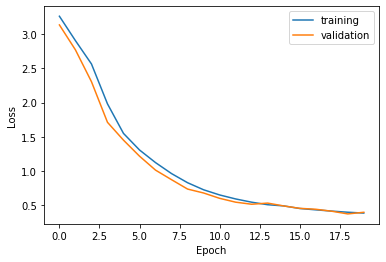

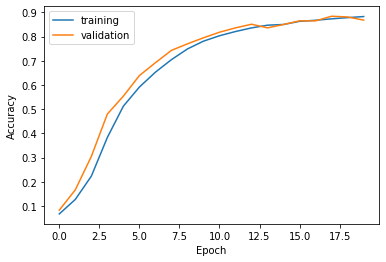

In [0]:
# plot loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
lstm.compile(optimizer=keras.optimizers.SGD(lr=1e-5, momentum=0.9, decay=1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Train on 56721 samples, validate on 1000 samples
Epoch 1/10
56721/56721 [==============================] - 82s 1ms/step - loss: 0.3513 - acc: 0.8943 - val_loss: 0.3808 - val_acc: 0.8820
Epoch 2/10
56721/56721 [==============================] - 74s 1ms/step - loss: 0.3503 - acc: 0.8931 - val_loss: 0.3763 - val_acc: 0.8800
Epoch 3/10
56721/56721 [==============================] - 75s 1ms/step - loss: 0.3481 - acc: 0.8948 - val_loss: 0.3709 - val_acc: 0.8870
Epoch 4/10
56721/56721 [==============================] - 74s 1ms/step - loss: 0.3411 - acc: 0.8976 - val_loss: 0.3686 - val_acc: 0.8850
Epoch 5/10
56721/56721 [==============================] - 75s 1ms/step - loss: 0.3384 - acc: 0.8976 - val_loss: 0.4278 - val_acc: 0.8630
Epoch 6/10
56721/56721 [==============================] - 74s 1ms/step - loss: 0.3450 - acc: 0.8950 - val_loss: 0.3890 - val_acc: 0.8800
Epoch 7/10
56721/56721 [==============================] - 74s 1ms/step - loss: 0.3364 - acc: 0.8988 - val_loss: 0.3705 - val_acc:

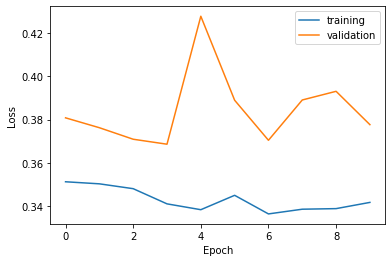

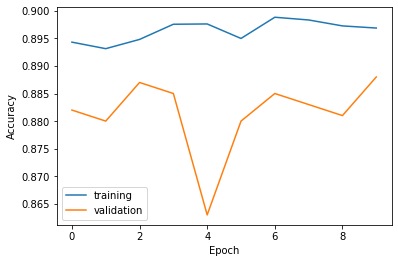

In [0]:
# plot loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
lstm.save_weights('drive/My Drive/Speech/trained/lstm_raw')

In [0]:
lstm.load_weights('drive/My Drive/Speech/trained/lstm_raw')
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print('Final testing accuracy:', lstm.evaluate(x_test, y_test, verbose=0)[1])

Final testing accuracy: 0.8984285714285715
